In [1]:
import numpy as np
import pandas as pd
import os
import sys
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import optuna
import random
import joblib
import math
import ast
import logging
from msig import Motif, NullModel
from config import RESULTS_MOTIF_DIR, RESULTS_DIR, IMAGES_DIR, DATA_DIR, DATASET_PATH, TOWNSHIP_NAME, VARIABLES, NORMALIZE_FLAGS, STUMPY_EXCL_ZONE_DENOM, TOP_K_MP, INCLUDE, NORMALIZE, SUBSQUENCES_LENGTHS

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")


if '__file__' in globals():
    # For standalone scripts
    base_dir = os.path.dirname(__file__)
else:
    # For Jupyter or interactive environments
    base_dir = os.getcwd()

# Add the parent directory of `utils` to the Python path
sys.path.append(os.path.abspath(os.path.join(base_dir, "../")))

2025-01-27 20:28:04,355 - INFO - Results will be saved in: /home/mgsilva/motifpred/results/populationdensity
2025-01-27 20:28:04,356 - INFO - Images will be saved in: /home/mgsilva/motifpred/images/populationdensity
2025-01-27 20:28:04,356 - INFO - Data will be accessed from: /home/mgsilva/motifpred/data/populationdensity


Results will be saved in: /home/mgsilva/motifpred/results/populationdensity
Images will be saved in: /home/mgsilva/motifpred/images/populationdensity
Data will be accessed from: /home/mgsilva/motifpred/data/populationdensity


In [2]:

mp_stats_table = pd.read_csv(
    RESULTS_DIR / f"mp_stats_table_normalized_{NORMALIZE}_top_{TOP_K_MP}.csv"
)
m = 4
mp_stats_table = mp_stats_table[mp_stats_table["m"] == m]
top_motifs = mp_stats_table.sort_values(by="#Matches", ascending=False).head(5)
top_motifs = top_motifs[["m", "Indices"]]
top_motif = top_motifs.iloc[0]
print(top_motif)

motif_size = top_motif["m"]
motif_indexes = ast.literal_eval(top_motif["Indices"])
len(motif_indexes)


m                                                          4
Indices    [1331, 792, 582, 872, 1160, 1359, 1810, 539, 6...
Name: 38, dtype: object


81

In [3]:
# read csv
data_df = pd.read_csv(
    DATASET_PATH,
    parse_dates=["one_time"],
    date_format="%Y-%m-%d %H:%M:%S",
    index_col=0,
)

data_df = data_df[data_df["township_name"] == TOWNSHIP_NAME]
#set index to one_time and township_name
data_df = data_df.set_index(["one_time", "township_name"]).sort_index()[VARIABLES]
data = data_df.to_numpy().T
data_univar = data[0]
data_df

,,sum_terminals
one_time,township_name,
2021-09-15 00:00:00,Avenidas Novas,260700.0
2021-09-15 01:00:00,Avenidas Novas,276675.0
2021-09-15 02:00:00,Avenidas Novas,284563.0
2021-09-15 03:00:00,Avenidas Novas,279563.0
2021-09-15 04:00:00,Avenidas Novas,281460.0
...,...,...
2021-11-30 19:00:00,Avenidas Novas,391367.0
2021-11-30 20:00:00,Avenidas Novas,352361.0
2021-11-30 21:00:00,Avenidas Novas,388246.0


In [4]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [5]:
from utils.utils import create_motif_dataset

lookback_period = 100 #window size
step = 1 #step size for the sliding window
forecast_period = 50 #forward window size

#X_series: past window, X_indices: indexes of the motif in the window,  y: next relative index of the motif
X_series, X_indices, X_mask, y = create_motif_dataset(data, lookback_period, step, forecast_period, motif_indexes, motif_size)

# X_series, X2, and y are now PyTorch tensors
print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X_series shape: torch.Size([1619, 100, 1])
X_indices shape: torch.Size([1619, 9, 1])
X_mask shape: torch.Size([1619, 100])
y shape: torch.Size([1619, 1])


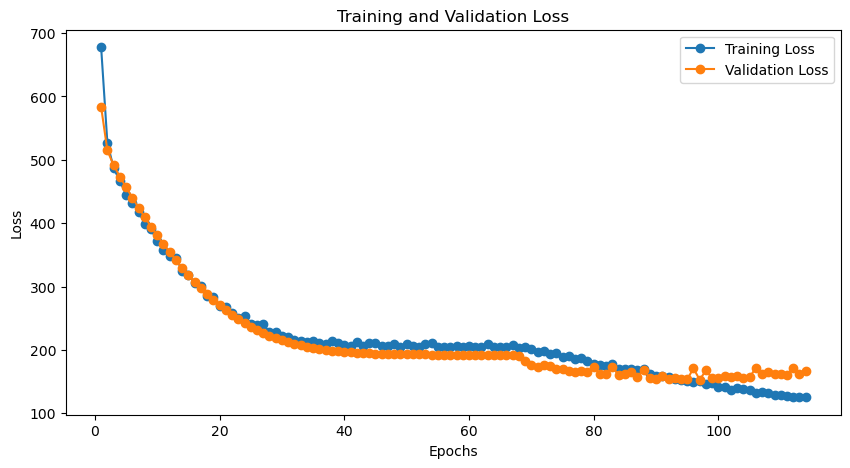

Best epoch: 96
Best Train Loss: 150.6314955920708, Best Validation Loss: 152.80267333984375
Test Loss: 181.9878692626953, Test MAE: 11.28747272491455, Test RMSE: 13.490287780761719


In [6]:
from models.transformer_pytorch import TimeSeriesTransformer
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest

n_trials = 5
num_epochs = 500
model_type = "Transformer"
model_name = "TransformerSeries"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "d_model": {
        "type": "categorical",
        "args": [[64, 128, 256, 512]]
    },
    "n_heads": {
        "type": "categorical",
        "args": [[2, 4, 8, 16]]
    },
    "e_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]
    },
    "dim_feedforward": {
        "type": "categorical",
        "args": [[128, 256, 512]]
    },
    "dropout": {
        "type": "float",
        "args": [0.0, 0.5]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}

model_params_keys = ["d_model", "n_heads", "e_layers", "dim_feedforward", "dropout"]


model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

X = {"X_series": X_series}
#run_optuna_study(pipeline.run_train_val_test, TimeSeriesTransformer, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)
plot_best_model_results_traindevtest( study.trials_dataframe(),
    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png")
)

print(f"Best epoch: {best_epoch}")
print(f"Best Train Loss: {train_losses[best_epoch]}, Best Validation Loss: {val_losses[best_epoch]}")
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")


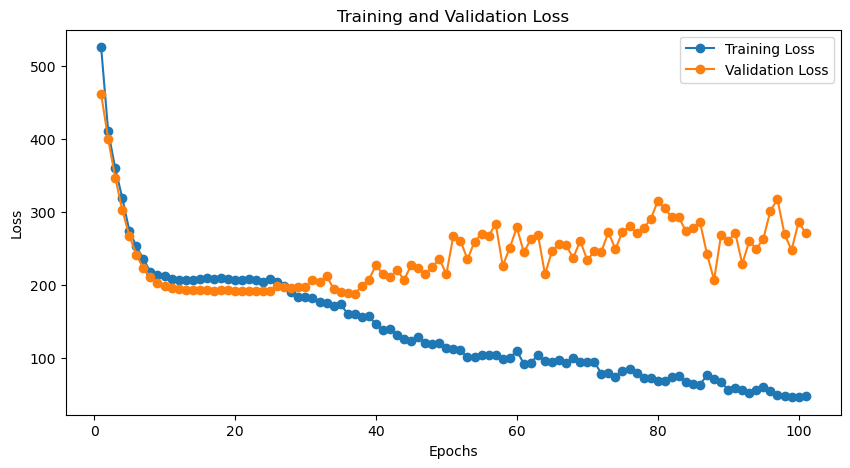

Best epoch: 36
Best Train Loss: 159.38599868047805, Best Validation Loss: 187.26153564453125
Test Loss: 333.3349609375, Test MAE: 14.28093147277832, Test RMSE: 18.257463455200195


In [7]:
from models.transformer_pytorch import TimeSeriesTransformer
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest

n_trials = 5
num_epochs = 500
model_type = "Transformer"
model_name = "TransformerSeries_Masking"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "d_model": {
        "type": "categorical",
        "args": [[64, 128, 256, 512]]
    },
    "n_heads": {
        "type": "categorical",
        "args": [[2, 4, 8, 16]]
    },
    "e_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]
    },
    "dim_feedforward": {
        "type": "categorical",
        "args": [[128, 256, 512]]
    },
    "dropout": {
        "type": "float",
        "args": [0.0, 0.5]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}

model_params_keys = ["d_model", "n_heads", "e_layers", "dim_feedforward", "dropout"]


model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

X = {"X_series": X_series, "X_mask": X_mask}
#run_optuna_study(pipeline.run_train_val_test, TimeSeriesTransformer, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
train_losses, val_losses,best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)
plot_best_model_results_traindevtest( study.trials_dataframe(),
    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png")
)

print(f"Best epoch: {best_epoch}")
print(f"Best Train Loss: {train_losses[best_epoch]}, Best Validation Loss: {val_losses[best_epoch]}")
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

In [11]:
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test

epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, TimeSeriesTransformer, model_type, model_params_keys, num_epochs =num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)

print(f"Test Loss: {test_losses}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), 0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))





Best hyperparameters: {'learning_rate': 0.0003935723458895795, 'd_model': 256, 'n_heads': 4, 'e_layers': 3, 'dim_feedforward': 512, 'dropout': 0.23119787082872928, 'batch_size': 64}
Early stopping at epoch 101, with best epoch being 36
Validation Loss: 187.26153564453125
Test Loss: 333.3349609375
Test MAE: 14.28093147277832
Test RMSE: 18.257463455200195
Test Loss: 333.3349609375, Test MAE: 14.28093147277832, Test RMSE: 18.257463455200195
